In [3]:
import numpy as np
import pandas as pd
import scipy.integrate as spi
from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from datetime import timedelta

In [4]:
# Barangay Population
population = 407437

df_barangay = pd.read_csv('combined_binan_actual_cases.csv', parse_dates=['date'])
df = df_barangay[df_barangay['barangay_Res'] == 'Biñan']

# training and tests of different time range
train_data_test1 = df[(df['date'] >= '2021-05-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test2 = df[(df['date'] >= '2021-06-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test3 = df[(df['date'] >= '2021-08-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
train_data_test4 = df[(df['date'] >= '2021-10-13') & 
                    (df['date'] <= '2022-01-13') 
                    ]
test_data = df[(df['date'] >= '2022-01-14') & 
                   (df['date'] <= '2022-02-13') 
                  ]


# Setting number of days of training and prediction
n_days_train1 = len(train_data_test1)
n_days_train2 = len(train_data_test2)
n_days_train3 = len(train_data_test3)
n_days_train4 = len(train_data_test4)
n_pred_days = len(test_data)

# Getting the number of different compartment on different days
train_cases_test1 = train_data_test1['count_Conf_age_80_above'].values
train_cases_test2 = train_data_test2['count_Conf_age_80_above'].values
train_cases_test3 = train_data_test3['count_Conf_age_80_above'].values
train_cases_test4 = train_data_test4['count_Conf_age_80_above'].values
test_cases = test_data['count_Conf_age_80_above'].values

results = []

In [5]:

model = CmdStanModel(stan_file=r'C:\\Users\\jhnbr\\Documents\\Github\SEIR_DJANGO-WebTest\\transformation\dataset\\models\seir_model.stan')

def seir_ode(y, t,  beta, sigma, gamma):
    S, E, I, R = y
    dS_dt = -beta * I * S / population
    dE_dt = beta * I * S / population - sigma * E
    dI_dt = sigma * E - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dE_dt, dI_dt, dR_dt]

def objective_function(params, cases,initial_conditions):
    beta, sigma, gamma = params
    t = np.arange(len(cases))
    
    # Solve SEIR Model
    solution = odeint(seir_ode, initial_conditions, t, args=(beta, sigma, gamma))
    I_pred = solution[:, 2]  # Predicted Infected
    I_pred = np.clip(I_pred, 0, None)  # Ensure non-negative predictions

    # Calculate Error
    I_actual = cases
    error = np.mean((I_pred - I_actual) ** 2)
    
    # Regularization term to prevent extreme parameter values
    reg_term = 0.01 * (beta ** 2 + sigma ** 2 + gamma ** 2)
    
    return error + reg_term

bounds = [(0.0001, 2.0), (0.0001, 1.0), (0.0001, 1.0)]  # Wider bounds


def get_initial_state(train_data):
    E = train_data['count_Specimen_age_80_above'].values[0]
    I = train_data['count_Conf_age_80_above'].values[0]
    R = train_data['count_Reco_age_80_above'].values[0]
    S = population - E - I - R
    initial_conditions = [S, E, I, R]

    e_test = train_data['count_Specimen_age_80_above'].values[-1]
    i_test = train_data['count_Conf_age_80_above'].values[-1]
    r_test = train_data['count_Reco_age_80_above'].values[-1]
    s_test = population - e_test - i_test - r_test
    initial_conditions_test = [s_test, e_test,i_test, r_test]
    return initial_conditions, initial_conditions_test


# Getting the arranged days of all training sets
def get_arrange_days(train_data,test_data):
    return np.arange(len(train_data)), np.arange(len(train_data), len(train_data) + len(test_data) )





# Test 1: 8 months Training | 1 Month Training

# Bayesian

In [6]:

stan_data = {
    "n_days": n_days_train1, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train1 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test1.tolist(), # active cases on different days
    "i0": train_cases_test1[0] ,  # Initial infectious individuals
    "e0":train_data_test1['count_Specimen_age_80_above'].values[0],  # Initial exposed individuals
    "r0":train_data_test1['count_Reco_age_80_above'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")


results.append(["Test 1: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])


15:59:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▋        | 00:33 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 01:47 Iteration: 100 / 1000 [ 10%]  (Warmup)
chain 1 |███▎      | 03:06 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 04:11 Iteration: 300 / 1000 [ 30%]  (Warmup)







chain 1 |█████▊    | 06:21 Iteration: 500 / 1000 [ 50%]  (Warmup)









chain 1 |██████▋   | 08:26 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 09:44 Iteration: 600 / 1000 [ 60%]  (Sampling)
chain 1 |████████▎ | 11:03 Iteration: 700 / 1000 [ 70%]  (Sampling)
chain 1 |█████████▏| 12:25 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 18:21 Sampling completed                      
chain 2 |██████████| 18:21 Sampling completed                      
chain 3 |██████████| 18:21 Sampling completed                      
chain 4 |██████████| 18:21 Sampling completed                      


16:18:06 - cmdstanpy - INFO - CmdStan done processing.


16:18:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 103 iterations at max treedepth (20.6%)
	Chain 4 had 31 divergent transitions (6.2%)
	Chain 4 had 1 iterations at max treedepth (0.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


beta: 0.845441286, gamma: 0.835591158, sigma: 0.8083891900000001
MAE : 5.044098027876456, NMAE: 0.5467378981264689, MSE: 35.760629990261904, RMSE: 5.98001922992409


# Simulated Annealing

In [7]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test1,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 1: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 0.13864487010068077, sigma: 1.0, gamma: 0.13978240187299779
MAE : 8.784077305809697, NMAE: 0.9521202674129392, MSE: 106.1534252106837, RMSE: 10.30307843368591


# SEIR

In [8]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 1: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])


MAE : 37270.738458844935, NMAE: 4039.835287497178, MSE: 2858376447.607931, RMSE: 53463.78631941373


# SEIR 2

In [9]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test1)
t_train, t_test = get_arrange_days(train_data_test1,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 1: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])


MAE : 15.84129933588273, NMAE: 1.717063914029247, MSE: 409.66795573447115, RMSE: 20.240255821863297


# Result

Bayesian
MAE : 5.044098027876456, NMAE: 0.5467378981264689, MSE: 35.760629990261904, RMSE: 5.98001922992409
Simulated Annealing
MAE : 8.784077305809697, NMAE: 0.9521202674129392, MSE: 106.1534252106837, RMSE: 10.30307843368591
SEIR
MAE : 37270.738458844935, NMAE: 4039.835287497178, MSE: 2858376447.607931, RMSE: 53463.78631941373


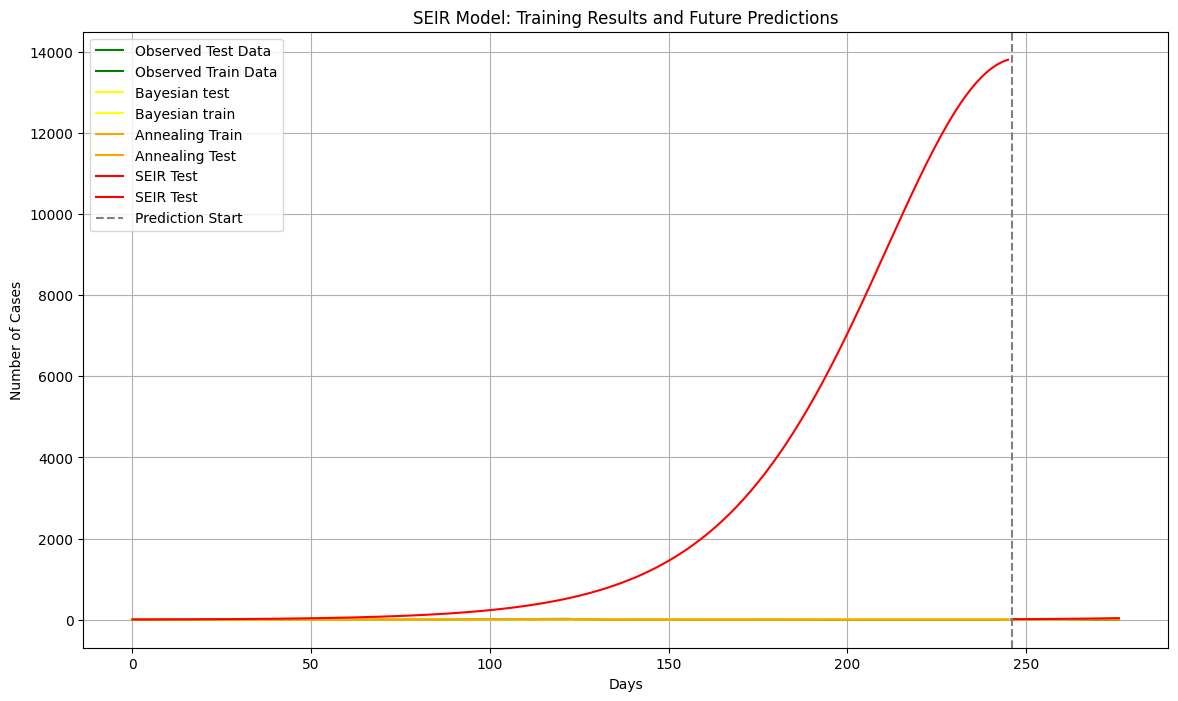

In [10]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
plt.figure(figsize=(14, 8))

# plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="red")
# Plot observed cases for training
plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")
# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("SEIR Model: Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

without seir

Bayesian
MAE : 5.044098027876456, NMAE: 0.5467378981264689, MSE: 35.760629990261904, RMSE: 5.98001922992409
Simulated Annealing
MAE : 8.784077305809697, NMAE: 0.9521202674129392, MSE: 106.1534252106837, RMSE: 10.30307843368591


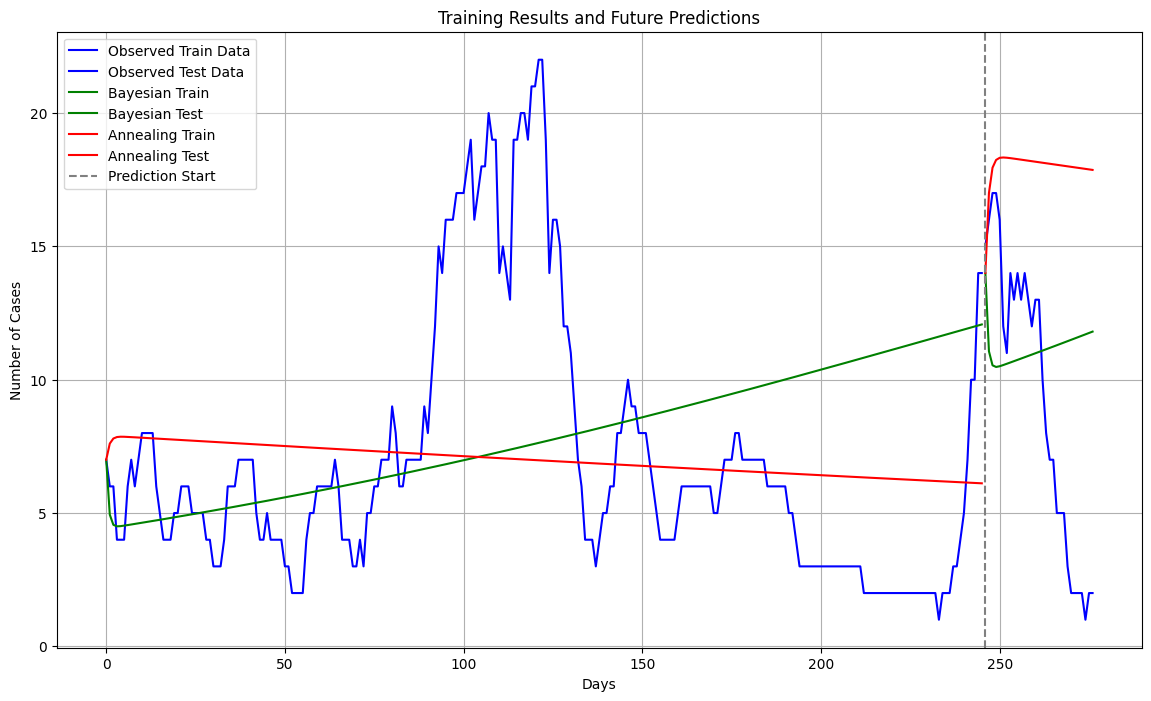

In [11]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")


plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test1,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()


# Test 2:  7 Months Training | 1 Month Prediction

# Bayesian

In [12]:

stan_data = {
    "n_days": n_days_train2, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train2 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test2.tolist(), # active cases on different days
    "i0": train_cases_test2[0] ,  # Initial infectious individuals
    "e0":train_data_test2['count_Specimen_age_80_above'].values[0],  # Initial exposed individuals
    "r0":train_data_test2['count_Reco_age_80_above'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
results.append(["Test 2: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])




16:18:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▋        | 00:19 Iteration:   1 / 1000 [  0%]  (Warmup)

chain 1 |██▌       | 00:40 Iteration: 100 / 1000 [ 10%]  (Warmup)





chain 1 |███▎      | 01:03 Iteration: 200 / 1000 [ 20%]  (Warmup)
chain 1 |████▏     | 01:29 Iteration: 300 / 1000 [ 30%]  (Warmup)





chain 1 |█████▊    | 02:13 Iteration: 500 / 1000 [ 50%]  (Warmup)



chain 1 |██████▋   | 03:00 Iteration: 501 / 1000 [ 50%]  (Sampling)



chain 1 |███████▌  | 03:36 Iteration: 600 / 1000 [ 60%]  (Sampling)



chain 1 |████████▎ | 04:03 Iteration: 700 / 1000 [ 70%]  (Sampling)

chain 1 |██████████| 04:39 Sampling completed                      
chain 2 |██████████| 04:39 Sampling completed                      
chain 3 |██████████| 04:39 Sampling completed                      
chain 4 |██████████| 04:39 Sampling completed                      


16:23:05 - cmdstanpy - INFO - CmdStan done processing.
16:23:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.2%)
	Chain 3 had 28 divergent transitions (5.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



beta: 0.8946799975, gamma: 0.755369524, sigma: 0.788248826
MAE : 26.3678267810315, NMAE: 2.85805115458733, MSE: 1265.961781929957, RMSE: 35.58035668637903


# Simulated Annealing

In [13]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test2,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 2: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 0.0001, sigma: 0.06521389291225295, gamma: 0.0006851537140391823
MAE : 8.956489378049636, NMAE: 0.9708082892291562, MSE: 119.4127887752903, RMSE: 10.927615877916386


# SEIR

In [14]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 2: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])



MAE : 37270.73845884556, NMAE: 4039.8352874972456, MSE: 2858376447.607966, RMSE: 53463.78631941406


# SEIR 2

In [15]:
initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test2)
t_train, t_test = get_arrange_days(train_data_test2,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 2: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 15.841299335882855, NMAE: 1.7170639140292603, MSE: 409.6679557344793, RMSE: 20.2402558218635



# Result

Bayesian
MAE : 26.3678267810315, NMAE: 2.85805115458733, MSE: 1265.961781929957, RMSE: 35.58035668637903
Simulated Annealing
MAE : 8.956489378049636, NMAE: 0.9708082892291562, MSE: 119.4127887752903, RMSE: 10.927615877916386
SEIR
MAE : 37270.73845884556, NMAE: 4039.8352874972456, MSE: 2858376447.607966, RMSE: 53463.78631941406
SEIR 2
MAE : 15.841299335882855, NMAE: 1.7170639140292603, MSE: 409.6679557344793, RMSE: 20.2402558218635


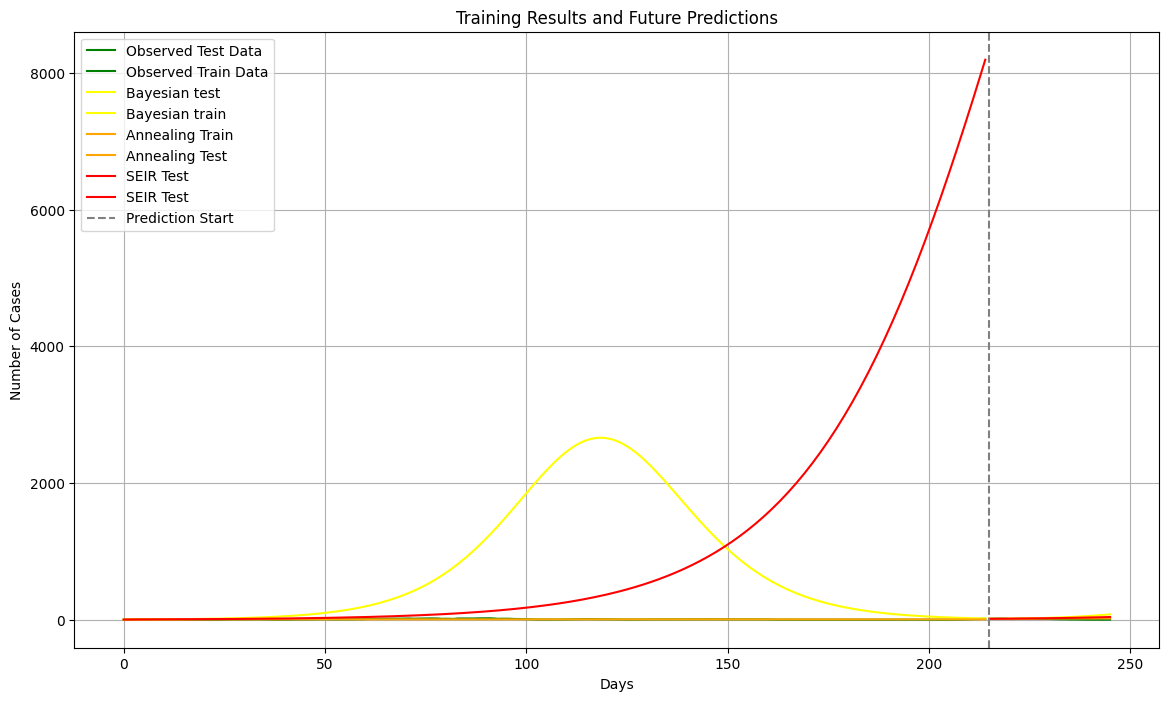

In [16]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test2,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

Without SEIR

Bayesian
MAE : 26.3678267810315, NMAE: 2.85805115458733, MSE: 1265.961781929957, RMSE: 35.58035668637903
Simulated Annealing
MAE : 8.956489378049636, NMAE: 0.9708082892291562, MSE: 119.4127887752903, RMSE: 10.927615877916386


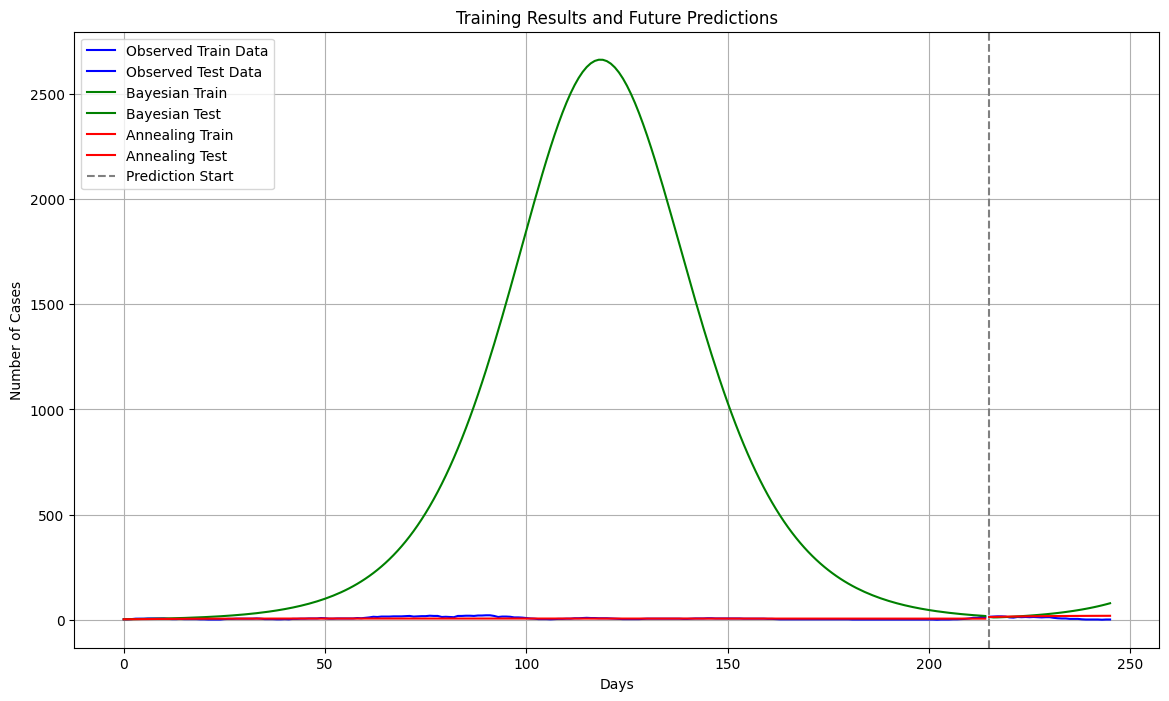

In [17]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")



plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test2,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Test 3: 5 Months Training | 1 Month Prediction

# Bayesian

In [18]:

stan_data = {
    "n_days": n_days_train3, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train3 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test3.tolist(), # active cases on different days
    "i0": train_cases_test3[0] ,  # Initial infectious individuals
    "e0":train_data_test3['count_Specimen_age_80_above'].values[0],  # Initial exposed individuals
    "r0":train_data_test3['count_Reco_age_80_above'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")

results.append(["Test 3: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])



16:23:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:05 Iteration:   1 / 1000 [  0%]  (Warmup)
chain 1 |██▌       | 00:16 Iteration: 100 / 1000 [ 10%]  (Warmup)

chain 1 |███████▌  | 00:51 Iteration: 600 / 1000 [ 60%]  (Sampling)

chain 1 |████████▎ | 00:57 Iteration: 700 / 1000 [ 70%]  (Sampling)
chain 1 |██████████| 01:08 Iteration: 900 / 1000 [ 90%]  (Sampling)


























chain 1 |██████████| 03:36 Sampling completed                      
chain 2 |██████████| 03:36 Sampling completed                      
chain 3 |██████████| 03:36 Sampling completed                      
chain 4 |██████████| 03:36 Sampling completed                      


16:26:49 - cmdstanpy - INFO - CmdStan done processing.



beta: 0.7944158170000001, gamma: 0.6789150285000001, sigma: 0.6869863399999999
MAE : 18.822149038414008, NMAE: 2.0401630076602593, MSE: 631.385335191128, RMSE: 25.127382179429834


# Simulated Annealing

In [19]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test3,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")

results.append(["Test 3: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])

beta: 0.0001, sigma: 0.23167391184475655, gamma: 0.016379065022071728
MAE : 6.830127489063298, NMAE: 0.7403285040593085, MSE: 63.1337030794603, RMSE: 7.945671971549058


# SEIR

In [20]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")

results.append(["Test 3: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])

MAE : 37270.73845884619, NMAE: 4039.8352874973134, MSE: 2858376447.6080613, RMSE: 53463.786319414954


# SEIR 2

In [21]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test3)
t_train, t_test = get_arrange_days(train_data_test3,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 3: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 15.841299335882647, NMAE: 1.7170639140292379, MSE: 409.66795573446814, RMSE: 20.240255821863226


# Result

Bayesian
MAE : 18.822149038414008, NMAE: 2.0401630076602593, MSE: 631.385335191128, RMSE: 25.127382179429834
Simulated Annealing
MAE : 6.830127489063298, NMAE: 0.7403285040593085, MSE: 63.1337030794603, RMSE: 7.945671971549058
SEIR
MAE : 37270.73845884619, NMAE: 4039.8352874973134, MSE: 2858376447.6080613, RMSE: 53463.786319414954
SEIR 2
MAE : 15.841299335882647, NMAE: 1.7170639140292379, MSE: 409.66795573446814, RMSE: 20.240255821863226


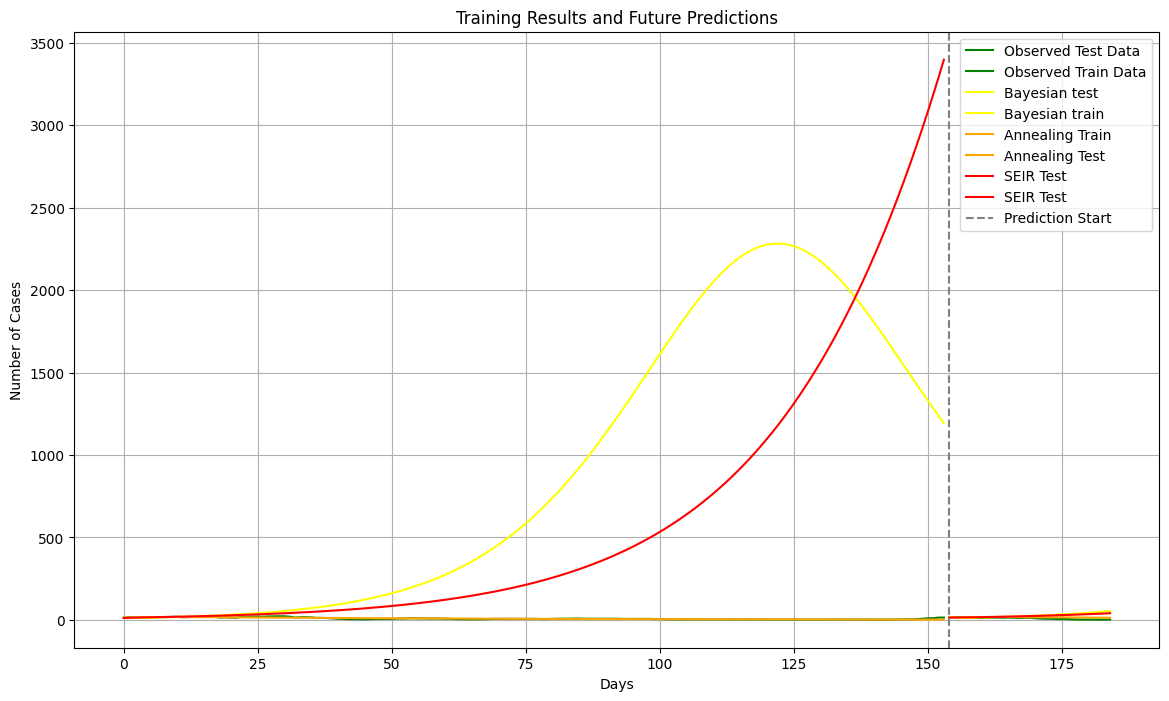

In [22]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test3,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

Without SEIR

Bayesian
MAE : 18.822149038414008, NMAE: 2.0401630076602593, MSE: 631.385335191128, RMSE: 25.127382179429834
Simulated Annealing
MAE : 6.830127489063298, NMAE: 0.7403285040593085, MSE: 63.1337030794603, RMSE: 7.945671971549058


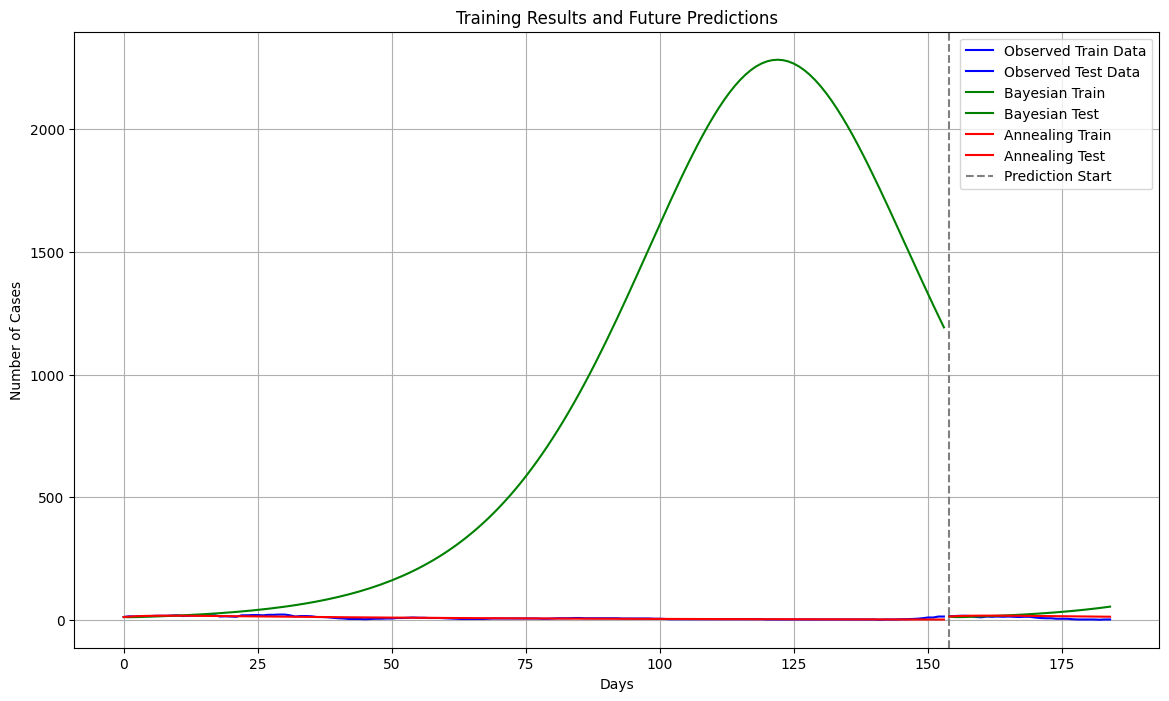

In [23]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")



plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test3,label="Observed Train Data", color="blue")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="green")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="red")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Test 4: 3 Months Training | 1 Month Prediction

# Bayesian

In [24]:

stan_data = {
    "n_days": n_days_train4, # number of days the model will be trained
    "t0": 0, # initial state
    "ts": np.arange(1, n_days_train4 + 1), # time steps
    "N": int(population), 
    "cases": train_cases_test4.tolist(), # active cases on different days
    "i0": train_cases_test4[0] ,  # Initial infectious individuals
    "e0":train_data_test4['count_Specimen_age_80_above'].values[0],  # Initial exposed individuals
    "r0":train_data_test4['count_Specimen_age_80_above'].values[0],  # Initial recovered individuals
}

fit = model.sample(data=stan_data, iter_warmup=500, iter_sampling=500, chains=4, parallel_chains=4,adapt_delta=0.9, seed=42)


lambda_ = np.mean(fit.stan_variable("infectious_rate"))
sigma = np.mean(fit.stan_variable("incubation_rate"))
gamma = np.mean(fit.stan_variable("recovery_rate"))
beta = lambda_
gamma = gamma

print(f'beta: {beta}, gamma: {gamma}, sigma: {sigma}')



initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_bayesian = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_bayesian = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_bayesian = mean_absolute_error(I_pred_test_bayesian, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_bayesian = mae_bayesian / norm_factor
mse_bayesian = mean_squared_error(test_cases,I_pred_test_bayesian)
rmse_bayesian = np.sqrt(mse_bayesian)


print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
results.append(["Test 4: Bayesian",   mse_bayesian, rmse_bayesian,mae_bayesian, nmae_bayesian,beta,  sigma,gamma])


16:26:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▋        | 00:01 Iteration:   1 / 1000 [  0%]  (Warmup)

chain 1 |██▌       | 00:04 Iteration: 100 / 1000 [ 10%]  (Warmup)
chain 1 |████▏     | 00:09 Iteration: 300 / 1000 [ 30%]  (Warmup)
chain 1 |██████▋   | 00:12 Iteration: 501 / 1000 [ 50%]  (Sampling)

chain 1 |██████████| 00:14 Iteration: 900 / 1000 [ 90%]  (Sampling)























chain 1 |██████████| 00:54 Sampling completed                      
chain 2 |██████████| 00:54 Sampling completed                      
chain 3 |██████████| 00:54 Sampling completed                      
chain 4 |██████████| 00:54 Sampling completed                      


16:27:51 - cmdstanpy - INFO - CmdStan done processing.
16:27:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 143 divergent transitions (28.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



beta: 0.6870962365, gamma: 0.596505539, sigma: 0.5847543040000001
MAE : 13.116089569408029, NMAE: 1.4216740442365345, MSE: 305.7775635029395, RMSE: 17.48649660460721


# Simulated Annealing

In [25]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

result = dual_annealing(objective_function, bounds, args=(train_cases_test4,initial_conditions,))
beta, sigma, gamma = result.x

print(f"beta: {beta}, sigma: {sigma}, gamma: {gamma}")

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_annealing = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_annealing = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)

mae_annealing = mean_absolute_error(I_pred_test_annealing, test_cases )
norm_factor = np.mean(np.abs(test_cases))
nmae_annealing = mae_annealing / norm_factor
mse_annealing = mean_squared_error(test_cases,I_pred_test_annealing)
rmse_annealing = np.sqrt(mse_annealing)



print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
results.append(["Test 4: Annealing",   mse_annealing, rmse_annealing,mae_annealing, nmae_annealing,beta, sigma,gamma ])


beta: 0.022753860368801986, sigma: 0.10379808892906132, gamma: 0.03294562212510819
MAE : 5.735663675388476, NMAE: 0.6216978109686809, MSE: 51.42602887594482, RMSE: 7.171194382802967


# SEIR

In [26]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

beta = 2.93  # Infection rate
sigma = 0.28  # Incubation rate
gamma = 0.33  # Recovery rate


predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir = mean_absolute_error(test_cases, I_pred_test_seir)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir = mae_seir / norm_factor
mse_seir = mean_squared_error(test_cases, I_pred_test_seir)
rmse_seir = mse_seir ** (1/2)

print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
results.append(["Test 4: SEIR 1",   mse_seir, rmse_seir,mae_seir, nmae_seir,beta, sigma,gamma])


MAE : 37270.738458845924, NMAE: 4039.835287497285, MSE: 2858376447.6079936, RMSE: 53463.78631941432


# SEIR 2

In [27]:

initial_conditions,initial_conditions_test = get_initial_state(train_data=train_data_test4)
t_train, t_test = get_arrange_days(train_data_test4,test_data)

beta = 0.198  # Infection rate
sigma = 0.3  # Incubation rate
gamma = 0.1389  # Recovery rate

predicted_solution = odeint(seir_ode, initial_conditions_test, t_test, args=(beta, sigma, gamma))
I_pred_test_seir2 = np.clip(predicted_solution[:, 2], 0, None)
I_pred_train_seir2 = np.clip(odeint(seir_ode, initial_conditions, t_train, args=(beta, sigma, gamma))[:, 2], 0, None)


# Evaluate the model (using test_cases for evaluation)
mae_seir2 = mean_absolute_error(test_cases, I_pred_test_seir2)
norm_factor = np.mean(np.abs(test_cases))
nmae_seir2 = mae_seir2 / norm_factor
mse_seir2 = mean_squared_error(test_cases, I_pred_test_seir2)
rmse_seir2 = mse_seir2 ** (1/2)

print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")
results.append(["Test 4: SEIR 2",   mse_seir2, rmse_seir2,mae_seir2, nmae_seir2,beta, sigma,gamma])

MAE : 15.841299335882535, NMAE: 1.7170639140292256, MSE: 409.6679557344614, RMSE: 20.240255821863055


# Results

Bayesian
MAE : 13.116089569408029, NMAE: 1.4216740442365345, MSE: 305.7775635029395, RMSE: 17.48649660460721
Simulated Annealing
MAE : 5.735663675388476, NMAE: 0.6216978109686809, MSE: 51.42602887594482, RMSE: 7.171194382802967
SEIR
MAE : 37270.738458845924, NMAE: 4039.835287497285, MSE: 2858376447.6079936, RMSE: 53463.78631941432
SEIR 2
MAE : 15.841299335882535, NMAE: 1.7170639140292256, MSE: 409.6679557344614, RMSE: 20.240255821863055


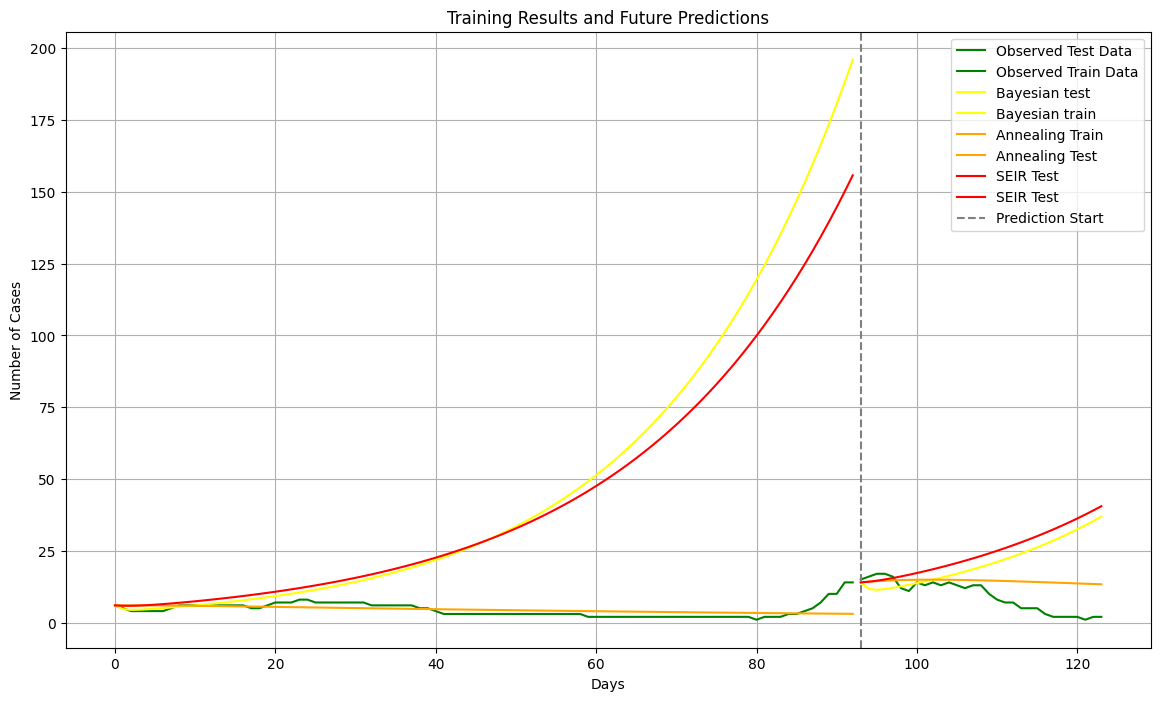

In [28]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")
print("SEIR 2")
print(f"MAE : {mae_seir2}, NMAE: {nmae_seir2}, MSE: {mse_seir2}, RMSE: {rmse_seir2}")


plt.figure(figsize=(14, 8))


plt.plot(t_test, test_cases, label="Observed Test Data", color="green")
plt.plot(t_train, train_cases_test4,label="Observed Train Data", color="green")


# Plot model results for training
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian test", color="yellow")
plt.plot(t_train, I_pred_train_bayesian, label="Bayesian train", color="yellow")

# Plot model results for training
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="orange")

plt.plot(t_test, I_pred_test_seir2, label="SEIR Test", color="red")
plt.plot(t_train, I_pred_train_seir2, label="SEIR Test", color="red")

# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

 Wtihout SEIR

Bayesian
MAE : 13.116089569408029, NMAE: 1.4216740442365345, MSE: 305.7775635029395, RMSE: 17.48649660460721
Simulated Annealing
MAE : 5.735663675388476, NMAE: 0.6216978109686809, MSE: 51.42602887594482, RMSE: 7.171194382802967
SEIR
MAE : 37270.738458845924, NMAE: 4039.835287497285, MSE: 2858376447.6079936, RMSE: 53463.78631941432


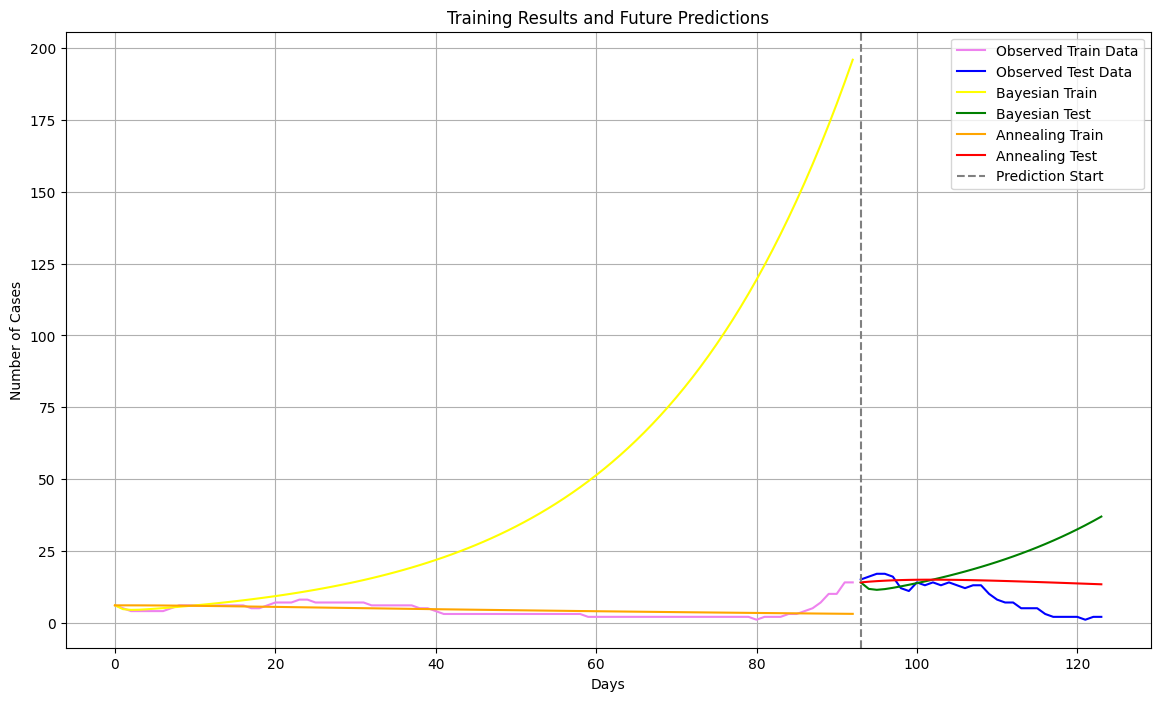

In [29]:
print("Bayesian")
print(f"MAE : {mae_bayesian}, NMAE: {nmae_bayesian}, MSE: {mse_bayesian}, RMSE: {rmse_bayesian}")
print("Simulated Annealing")
print(f"MAE : {mae_annealing}, NMAE: {nmae_annealing}, MSE: {mse_annealing}, RMSE: {rmse_annealing}")
print("SEIR")
print(f"MAE : {mae_seir}, NMAE: {nmae_seir}, MSE: {mse_seir}, RMSE: {rmse_seir}")


plt.figure(figsize=(14, 8))

# Plot observed data
plt.plot(t_train, train_cases_test4,label="Observed Train Data", color="violet")
plt.plot(t_test, test_cases, label="Observed Test Data", color="blue")

# Bayesian Plot
plt.plot(t_train, I_pred_train_bayesian,label="Bayesian Train", color="yellow")
plt.plot(t_test, I_pred_test_bayesian, label="Bayesian Test", color="green")

# Annealing plot
plt.plot(t_train, I_pred_train_annealing,label="Annealing Train", color="orange")
plt.plot(t_test, I_pred_test_annealing, label="Annealing Test", color="red")
#plt.plot(t_test, I_pred_test_seir, label="Annealing Test", color="orange")


# Add labels and legend
plt.axvline(x=len(I_pred_train_bayesian), linestyle='--', color='gray', label="Prediction Start")
plt.xlabel("Days")
plt.ylabel("Number of Cases")
plt.title("Training Results and Future Predictions")
plt.legend()
plt.grid()
plt.show()

# Download Result

In [30]:
df = pd.DataFrame(results, columns=["Test", "MSE",  "RMSE","MAE", "NMAE","Beta","Sigma", "Gamma" ])
df.to_csv("binan_result_80_above.csv", index=False)

print("Results saved to binan_result_80_above.csv")

Results saved to binan_result_80_above.csv
